In [1]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
# import necessary packages

import time
import geojson
import numpy as np
import pandas as pd
import openslide

from data_utils import *
from vis_utils import *
from measure_utils import *

In [2]:
DIR_WSI = "/Users/jinzhou/Desktop/USCAP/data/wsi"
DIR_ANN = "/Users/jinzhou/Desktop/USCAP/data/ann_geojsons"
DIR_SAVE_RESULTS = "/Users/jinzhou/Desktop/USCAP/results"
DIR_SAVE_FIGURE = "/Users/jinzhou/Desktop/USCAP/results/figures"

In [3]:
def artery_analysis(slide, ann_outer, ann, slide_boundries, wsi_id, artery_id, df):
    # get coordinates of arteries/media_outer_boundries
    cnt_outer_raw = ann_outer["geometry"]["coordinates"]
    cnt_outer = clean_coord(cnt_outer_raw)
    # based on outer, get middle and inner insides/intersecs
    cnts_middle = get_cnts_inside(ann, cnt_outer, target="Intima")
    cnts_inner = get_cnts_inside(ann, cnt_outer, target="Lumen")
    
    # adjust coords based on slide boundry
    (cnt_outer, cnts_middle, cnts_inner) = \
        adjust_artery_coords_by_boundry(cnt_outer, cnts_middle,
            cnts_inner, slide_boundries)
    
    # adjust coords based on artery boundry
    artery_boundry = get_border_of_cnt(cnt_outer, border=50)
    (cnt_outer, cnts_middle, cnts_inner) = \
        adjust_artery_coords_by_boundry(cnt_outer, cnts_middle,
            cnts_inner, artery_boundry) 
    (xmin, xmax, ymin, ymax) = artery_boundry
    
    curr_slide = slide[ymin:ymax, xmin:xmax].copy()
    curr_slide = plot_artery_ann(curr_slide, cnt_outer, cnts_middle, cnts_inner)
    (h, w) = curr_slide.shape[:2]
    curr_ann = np.zeros((h, w, 3), np.uint8)
    curr_ann = plot_artery_ann(curr_ann, cnt_outer, cnts_middle, cnts_inner)
    for idx, cnt_middle in enumerate(cnts_middle):
        for idy, cnt_inner in enumerate(cnts_inner):
            if cnt_polygon_test(cnt_inner, cnt_middle):

                # radial lines intersecs with excludde should be discarded
                exclude = cnts_middle[:idx] + cnts_middle[idx+1:]+ cnts_inner[:idy] + cnts_inner[idy+1:]
                thick_media, thick_intima, thick_wall = measure_thickness(wsi_id, artery_id, cnt_outer, cnt_middle, cnt_inner,
                                                            curr_ann, angle_width=10, exclude=exclude)
                row = {'WSI_ID':wsi_id, 'Artery_ID':artery_id+'_'+str(idx)+'_'+str(idy), 
                       'Thickness_Media_Abs':thick_media, 'Thickness_Intima_Abs':thick_intima,
                       'Thickness_Wall_Abs':thick_wall}
                df = df.append(row, ignore_index=True)
    save_img(curr_slide, DIR_SAVE_FIGURE, wsi_id, artery_id) 
    save_img(curr_ann, DIR_SAVE_FIGURE, wsi_id, artery_id+'_ann') 
    imshow_two_in_row(curr_slide, curr_ann)
    return df

def wsi_analysis(slide, ann, slide_boundries, wsi_id, df):
    
    # get ann for arteries/media_outer_boundries
    ann_outers = [ann_i for ann_i in ann if "name" in ann_i["properties"]]
    print("Number of arteries in {} is {}".format(wsi_id, len(ann_outers)))
    
    for i, ann_outer in enumerate(ann_outers):
        artery_id = ann_outer["properties"]["name"]
        print("Artery Id: ", artery_id)
        # artery-level analysis
        df = artery_analysis(slide, ann_outer, ann, slide_boundries, wsi_id, artery_id, df)
    return df

Working on Case:  12_26609_022_015 L2 TRI
stored slide size pyramid ((43648, 76800), (21824, 38400), (10912, 19200), (5456, 9600), (2728, 4800), (1364, 2400), (682, 1200), (341, 600), (170, 300), (85, 150))
fetched shape (9195, 14790, 4)
Number of arteries in 12_26609_022_015 L2 TRI is 10
Artery Id:  A04


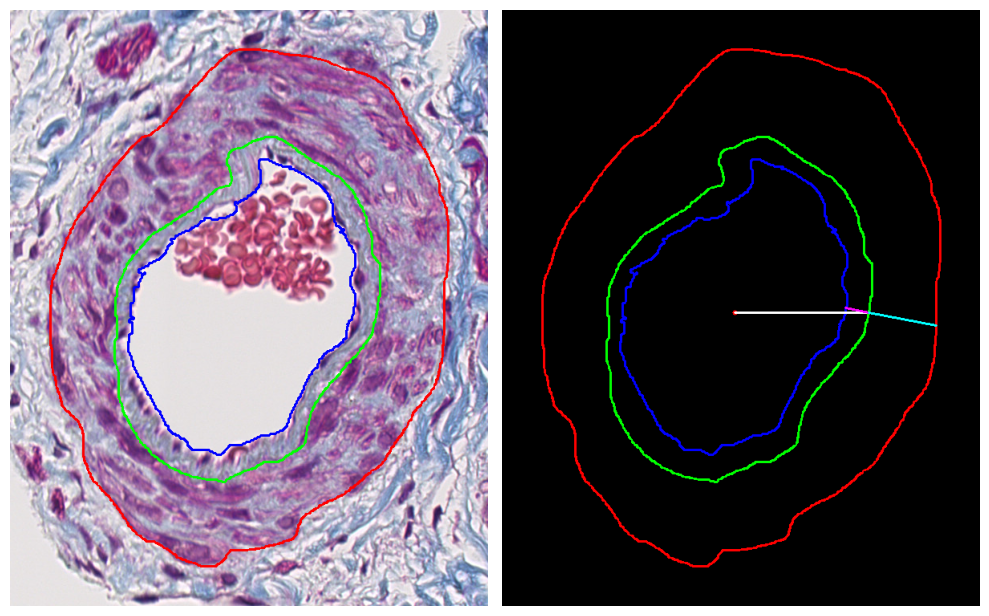

Artery Id:  A01


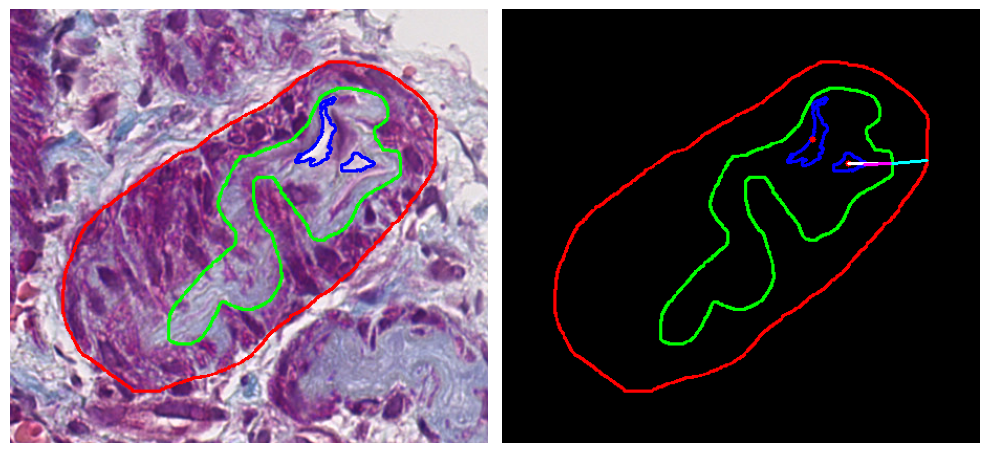

Artery Id:  A02


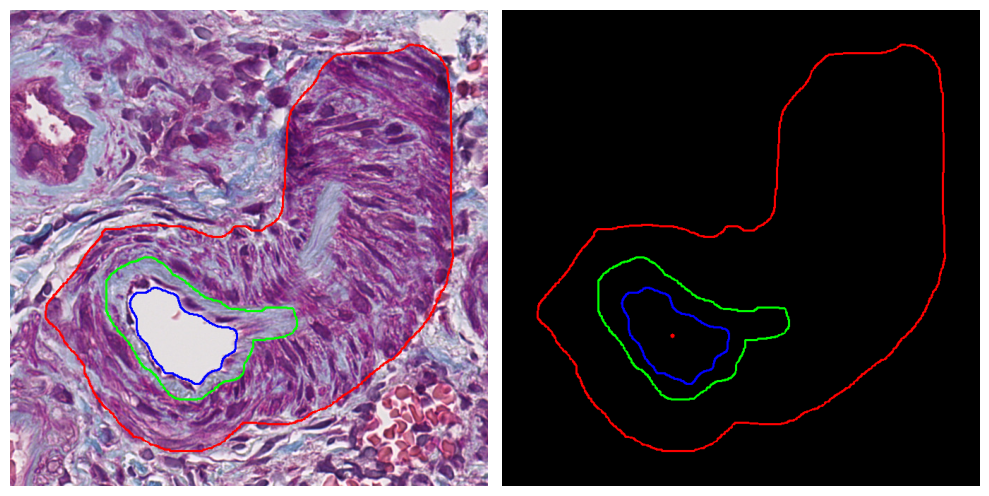

Artery Id:  A03


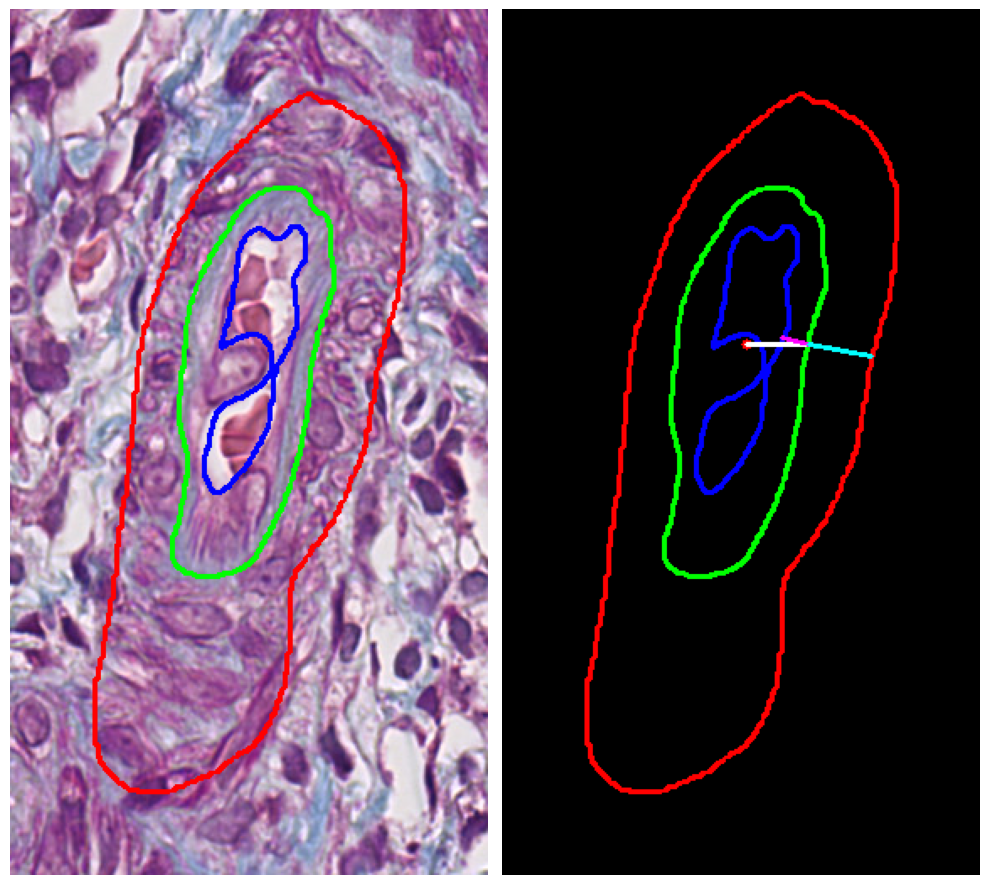

Artery Id:  A10


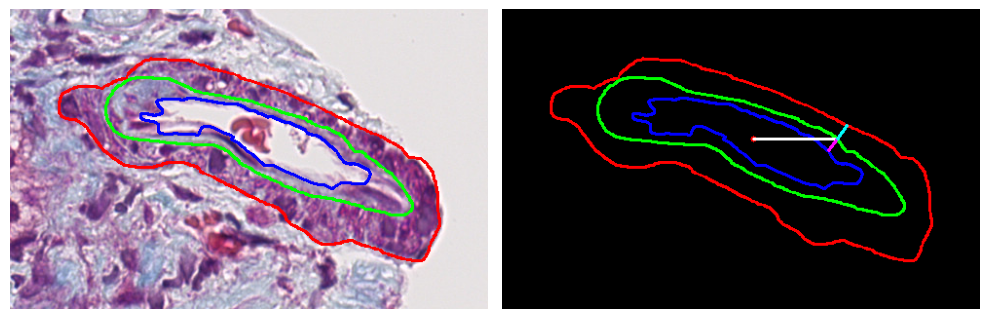

Artery Id:  A11


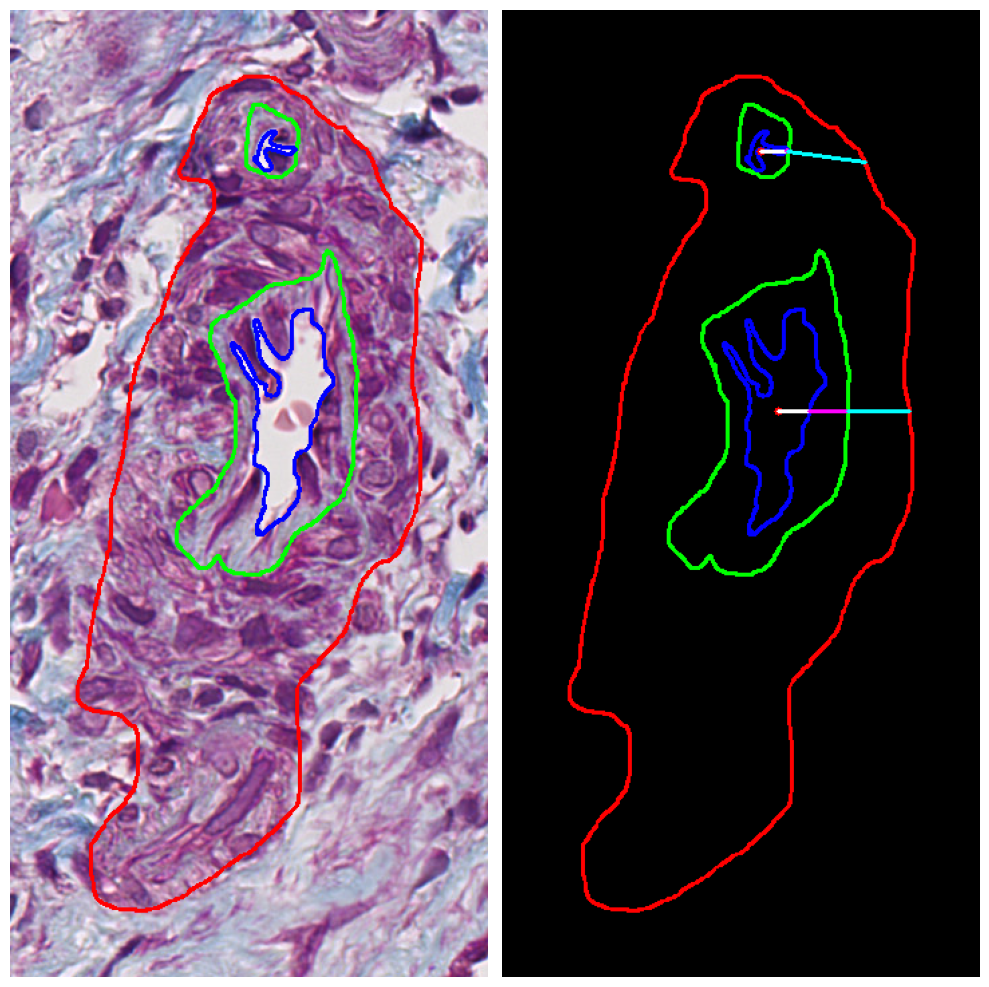

Artery Id:  A12


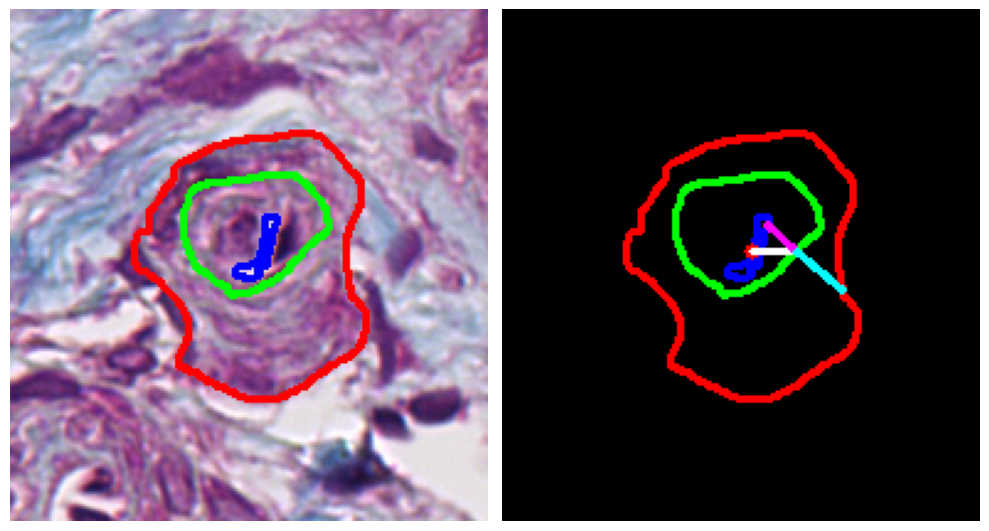

Artery Id:  A07


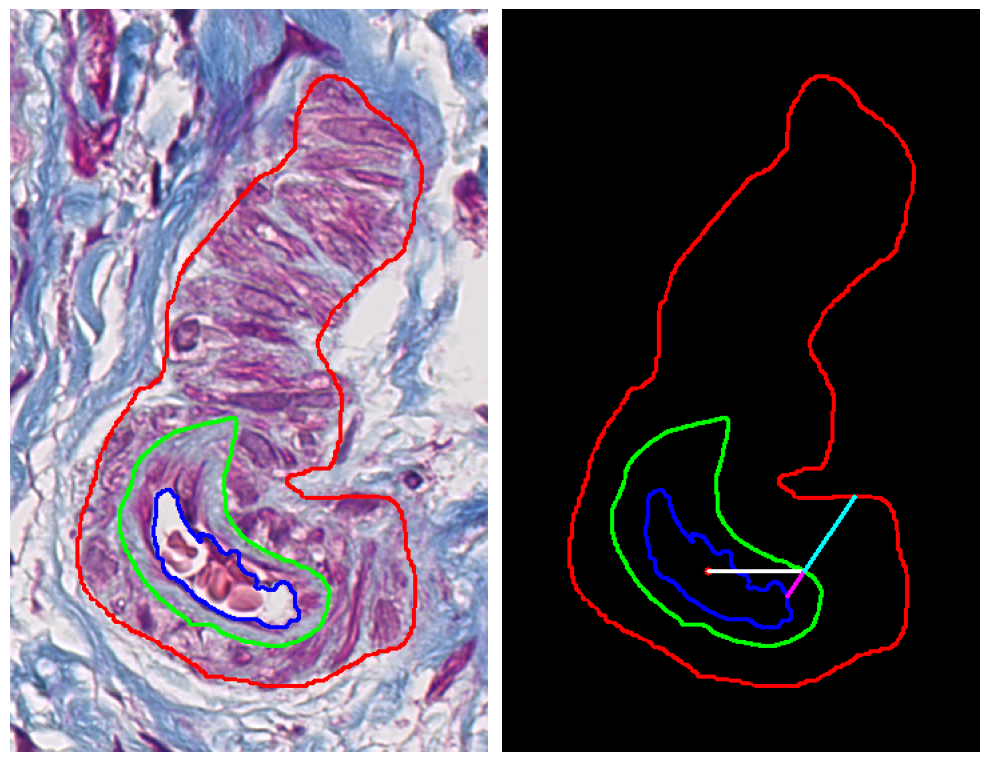

Artery Id:  A05


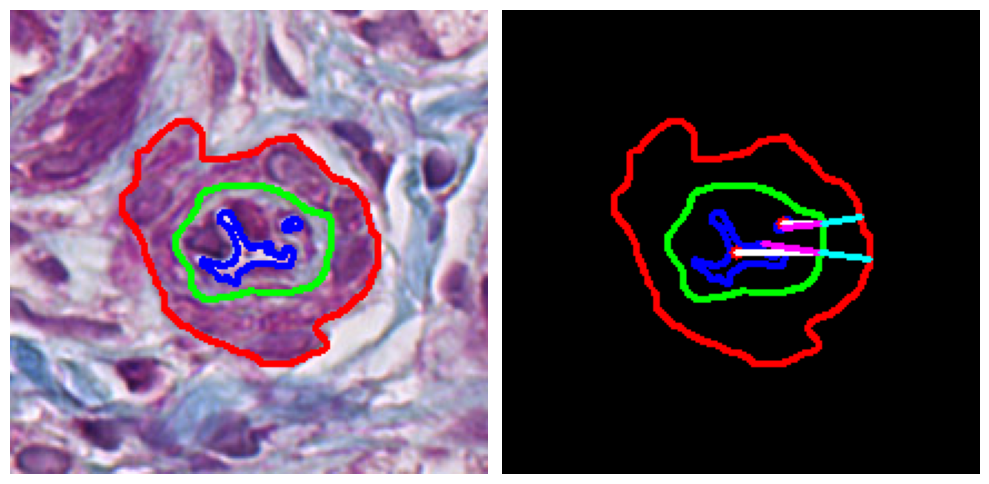

Artery Id:  A06


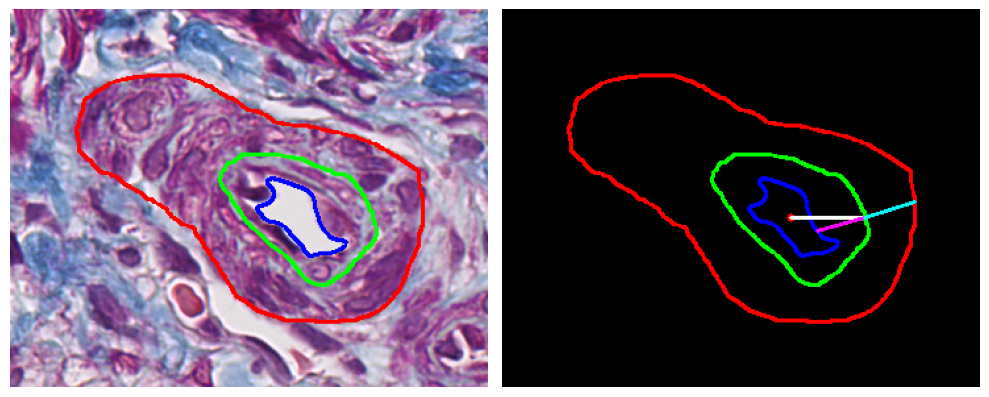

In total, it costs  11.894792795181274


In [4]:
start_time = time.time()
df = pd.DataFrame(columns = ['WSI_ID', 'Artery_ID', 'Area_Inner', 'Area_Middle', 'Area_Outer', 'Thickness_Media_Abs', 
                             'Thickness_Intima_Abs', 'Thickness_Wall_Abs'])
path_to_save = os.path.join(DIR_SAVE_RESULTS, "thickness.csv")

for wsi in os.listdir(DIR_WSI):
    if (not wsi.endswith(".ndpi")) and (not wsi.endswith(".svs")):
        continue
    start_time_wsi = time.time()
    path_wsi = os.path.join(DIR_WSI, wsi)
    wsi_id = wsi.split(".")[0]
    print("Working on Case: ", wsi_id)
    path_ann = os.path.join(DIR_ANN, wsi_id+".geojson")
    
    with open(path_ann) as f:
        exported = geojson.load(f)
        ann = exported['features']
    
    # find the area including arteries, make it easier to plot
    xmin, xmax, ymin, ymax = get_border_of_ann(ann)
    
    # open slide with formats of ndpi or svs
    slide_0 = openslide.OpenSlide(path_wsi)
    levels = slide_0.level_dimensions
    print("stored slide size pyramid",levels)

    # fetch levels[0] res of whole WSI with only the area including arteries
    slide = slide_0.read_region((xmin, ymin), 0, (xmax-xmin, ymax-ymin))
    slide = np.asarray(slide)
    print("fetched shape",slide.shape)
    # origin slide is in RGBA format, convert it to RGB and save to model data dir
    slide = cv2.cvtColor(slide, cv2.COLOR_RGBA2RGB)
    # WSI-level analysis
    df = wsi_analysis(slide, ann, (xmin, xmax, ymin, ymax), wsi_id, df)
    df.to_csv(path_to_save, index=False)  
    print(wsi_id, " costs, ", time.time() - start_time_wsi)
    print()

print("In total, it costs ", time.time() - start_time)